# Homework 4: Wine quality with optimization and regularization

Group 20: Marlena Reil, Christian Burmester, Maximilian Kalcher

In [257]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import MultiCursor
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

df = pd.read_csv('winequality-red.csv', sep=';')

print(df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

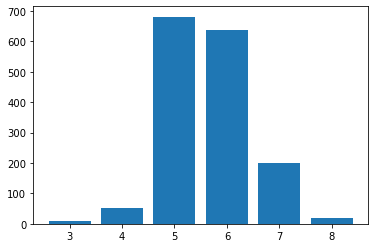

Mean of the quality : 5.6360225140712945
Standard deviation of the quality : 0.807569439734705
Median of the quality : 6.0


In [258]:
plt.bar(df['quality'].value_counts().index, df['quality'].value_counts().values)
plt.show()
print('Mean of the quality :', df['quality'].mean())
print('Standard deviation of the quality :', df['quality'].std())
print('Median of the quality :', df['quality'].median())

## Preprocessing

In [259]:
def make_binary(data):
    labels = data['quality']
    
    median = int(labels.median())
    mean = int(labels.mean())

    labels[labels < median] = 0
    labels[labels >= median] = 1

    return data

def normalize(data):

    norm = lambda x, x_max, x_min: (x - x_min) / (x_max - x_min)

    for column in list(data.columns):
        if column != "quality":

            temp = data[column].to_list()
            temp_max = max(temp)
            temp_min = min(temp)

            new_values = [norm(x, temp_max, temp_min) for x in temp]
            data[column] = new_values
    
    return data

def pipeline(data):

    data = normalize(data)
    data = make_binary(data)

    train, test, val = np.split(data.sample(frac=1), [int(data.shape[0] * 0.6), int(data.shape[0] * 0.8)])
    
    test_features = test.drop('quality', axis=1)
    test_labels = test['quality']

    train_features = train.drop('quality', axis=1)
    train_labels = train['quality']

    val_features = val.drop('quality', axis=1)
    val_labels = val['quality']

    train_tensor = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    test_tensor = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
    val_tensor = tf.data.Dataset.from_tensor_slices((val_features, val_labels))

    train_tensor = train_tensor.shuffle(100).batch(32).prefetch(1)
    test_tensor = test_tensor.shuffle(100).batch(32).prefetch(1)
    val_tensor = val_tensor.shuffle(100).batch(32).prefetch(1)

    train_tensor = train_tensor.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    test_tensor = test_tensor.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    val_tensor = val_tensor.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

    train_tensor = train_tensor.cache()
    test_tensor = test_tensor.cache()
    val_tensor = val_tensor.cache()

    return train_tensor, test_tensor, val_tensor

In [260]:
train_tensor, test_tensor, val_tensor = pipeline(df)

## Model

In [261]:
""" Model """

class Dense(tf.keras.layers.Layer):

    def __init__(self, units, activation):
        super(Dense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape): 
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)

    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

### Baseline Model (no regularization)

In [262]:
class Model_baseline(tf.keras.Model):

    def __init__(self):
        super(Model_baseline, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=4, activation=tf.nn.leaky_relu)
        self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
        self.out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    
    def call(self, inputs):
        """ Run data through network """
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        
        return x

    def training(self, input, target, loss, optimizer):
        """ Perform gradient descent and train variables """
        with tf.GradientTape() as tape:
            pred = self.call(input)
            loss_value = loss(target, pred)

        grads = tape.gradient(loss_value, self.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return loss_value

    def test(self, test_data, loss):
        """ Evaluate metrics """
        test_accuracy = []
        test_loss = []

        for (input, target) in test_data:
            pred = self.call(input)
            loss_value = loss(target, pred)

            sample_accuracy = np.round(pred, 0) == np.round(target, 0)
            sample_accuracy = np.mean(sample_accuracy)

            test_accuracy.append(np.mean(sample_accuracy))
            test_loss.append(loss_value.numpy())

        test_loss = tf.reduce_mean(test_loss)
        test_accuracy = tf.reduce_mean(test_accuracy)

        return test_loss, test_accuracy
    
    def validate(self, val_data, loss):
        """ Evaluate metrics """
        val_accuracy = []
        val_loss = []

        for (input, target) in val_data:
            pred = self.call(input)
            loss_value = loss(target, pred)

            sample_accuracy = np.round(pred, 0) == np.round(target, 0)
            sample_accuracy = np.mean(sample_accuracy)

            val_accuracy.append(np.mean(sample_accuracy))
            val_loss.append(loss_value.numpy())

        val_loss = tf.reduce_mean(val_loss)
        val_accuracy = tf.reduce_mean(val_accuracy)

        return val_loss, val_accuracy

### Penalty Model (regularized)

In [263]:
class Model_penalty(tf.keras.Model):

    def __init__(self):
        super(Model_penalty, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=4, activation=tf.nn.leaky_relu, \
                                            # add penalty on layer's kernel
                                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), \
                                            # add penalty on layer's bias
                                            bias_regularizer=tf.keras.regularizers.l2(1e-4), \
                                            # add penalty on layer's output
                                            activity_regularizer=tf.keras.regularizers.l2(1e-5))
        self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu, \
                                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), \
                                            bias_regularizer=tf.keras.regularizers.l2(1e-4), \
                                            activity_regularizer=tf.keras.regularizers.l2(1e-5))
        self.out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid, \
                                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), \
                                            bias_regularizer=tf.keras.regularizers.l2(1e-4), \
                                            activity_regularizer=tf.keras.regularizers.l2(1e-5))
    
    def call(self, inputs):
        """ Run data through network """
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        
        return x

    def training(self, input, target, loss, optimizer):
        """ Perform gradient descent and train variables """
        with tf.GradientTape() as tape:
            pred = self.call(input)
            loss_value = loss(target, pred)

        grads = tape.gradient(loss_value, self.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return loss_value

    def test(self, test_data, loss):
        """ Evaluate metrics """
        test_accuracy = []
        test_loss = []

        for (input, target) in test_data:
            pred = self.call(input)
            loss_value = loss(target, pred)

            sample_accuracy = np.round(pred, 0) == np.round(target, 0)
            sample_accuracy = np.mean(sample_accuracy)

            test_accuracy.append(np.mean(sample_accuracy))
            test_loss.append(loss_value.numpy())

        test_loss = tf.reduce_mean(test_loss)
        test_accuracy = tf.reduce_mean(test_accuracy)

        return test_loss, test_accuracy
    
    def validate(self, val_data, loss):
        """ Evaluate metrics """
        val_accuracy = []
        val_loss = []

        for (input, target) in val_data:
            pred = self.call(input)
            loss_value = loss(target, pred)

            sample_accuracy = np.round(pred, 0) == np.round(target, 0)
            sample_accuracy = np.mean(sample_accuracy)

            val_accuracy.append(np.mean(sample_accuracy))
            val_loss.append(loss_value.numpy())

        val_loss = tf.reduce_mean(val_loss)
        val_accuracy = tf.reduce_mean(val_accuracy)

        return val_loss, val_accuracy

### Penalty and Dropout Model (regularized)

In [264]:
class Model_penalty_and_dropout(tf.keras.Model):

    def __init__(self):
        super(Model_penalty_and_dropout, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=4, activation=tf.nn.leaky_relu, \
                                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), \
                                            bias_regularizer=tf.keras.regularizers.l2(1e-4), \
                                            activity_regularizer=tf.keras.regularizers.l2(1e-5))
        self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu, \
                                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), \
                                            bias_regularizer=tf.keras.regularizers.l2(1e-4), \
                                            activity_regularizer=tf.keras.regularizers.l2(1e-5))
        self.out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid, \
                                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), \
                                            bias_regularizer=tf.keras.regularizers.l2(1e-4), \
                                            activity_regularizer=tf.keras.regularizers.l2(1e-5))
        # dropout layer, rate is likelihood that neurons activation is set to zero during training
        self.dropout_layer = tf.keras.layers.Dropout(rate=0.2)
    
    def call(self, inputs):
        """ Run data through network """
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dropout_layer(x, training=True)
        x = self.out(x)
        
        return x

    def training(self, input, target, loss, optimizer):
        """ Perform gradient descent and train variables """
        with tf.GradientTape() as tape:
            pred = self.call(input)
            loss_value = loss(target, pred)

        grads = tape.gradient(loss_value, self.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return loss_value

    def test(self, test_data, loss):
        """ Evaluate metrics """
        test_accuracy = []
        test_loss = []

        for (input, target) in test_data:
            pred = self.call(input)
            loss_value = loss(target, pred)

            sample_accuracy = np.round(pred, 0) == np.round(target, 0)
            sample_accuracy = np.mean(sample_accuracy)

            test_accuracy.append(np.mean(sample_accuracy))
            test_loss.append(loss_value.numpy())

        test_loss = tf.reduce_mean(test_loss)
        test_accuracy = tf.reduce_mean(test_accuracy)

        return test_loss, test_accuracy
    
    def validate(self, val_data, loss):
        """ Evaluate metrics """
        val_accuracy = []
        val_loss = []

        for (input, target) in val_data:
            pred = self.call(input)
            loss_value = loss(target, pred)

            sample_accuracy = np.round(pred, 0) == np.round(target, 0)
            sample_accuracy = np.mean(sample_accuracy)

            val_accuracy.append(np.mean(sample_accuracy))
            val_loss.append(loss_value.numpy())

        val_loss = tf.reduce_mean(val_loss)
        val_accuracy = tf.reduce_mean(val_accuracy)

        return val_loss, val_accuracy

In [265]:
model = Model_baseline()
model.build(input_shape=(20,64))
model.compile()
print(model.summary())

Model: "model_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  260       
_________________________________________________________________
dense_4 (Dense)              multiple                  40        
_________________________________________________________________
dense_5 (Dense)              multiple                  9         
Total params: 309
Trainable params: 309
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [266]:
def training_loop(optimizer, epochs, penalty=False, dropout=False):
    """ External training loop """
    tf.keras.backend.clear_session()

    if(penalty and dropout):
        model = Model_penalty_and_dropout()
    elif(penalty and not(dropout)):
        model = Model_penalty()
    else:
        model = Model_baseline()
    
    loss = tf.keras.losses.BinaryCrossentropy()
    optimizer = optimizer(learning_rate=0.1)

    accuracies = []
    losses = []
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Test runthrough
    test_loss, test_accuracy = model.test(test_tensor, loss)

    accuracies.append(test_accuracy)
    losses.append(test_loss)

    # Train runthrough
    train_loss, train_accuracy = model.test(train_tensor, loss)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation runthrough
    val_loss, val_accuracy = model.validate(val_tensor, loss)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print('Optimizer: ',optimizer)
    print('Initial loss:', test_loss.numpy(), 'Initial accuracy:', test_accuracy.numpy(),'\n')

    for epoch in range(epochs):
      print(f'Epoch: {epoch}, accuracy of {accuracies[-1]}')

      epoch_loss = []

      for (input, target) in train_tensor:
          loss_value = model.training(input, target, loss, optimizer)
          epoch_loss.append(loss_value)

      train_losses.append(tf.reduce_mean(epoch_loss))
      train_accuracies.append(model.test(train_tensor, loss)[1])

      val_loss, val_accuracy = model.validate(val_tensor, loss)
      val_accuracies.append(val_accuracy)
      val_losses.append(val_loss)

      test_loss, test_accuracy = model.test(test_tensor, loss)
      accuracies.append(test_accuracy)
      losses.append(test_loss)

    print('\nFinal loss:', test_loss.numpy(), 'Final accuracy:', test_accuracy.numpy(),'\n')

    return accuracies, losses, train_accuracies, train_losses, val_accuracies, val_losses

## Intermediate results

In [267]:
sgd = training_loop(tf.keras.optimizers.SGD, epochs=10)

Optimizer:  <keras.optimizer_v2.gradient_descent.SGD object at 0x16a9bf280>
Initial loss: 0.692741 Initial accuracy: 0.5412109375 

Epoch: 0, accuracy of 0.5412109375
Epoch: 1, accuracy of 0.4607421875
Epoch: 2, accuracy of 0.459375
Epoch: 3, accuracy of 0.459375
Epoch: 4, accuracy of 0.459375
Epoch: 5, accuracy of 0.459375
Epoch: 6, accuracy of 0.459375
Epoch: 7, accuracy of 0.459375
Epoch: 8, accuracy of 0.459375
Epoch: 9, accuracy of 0.459375

Final loss: 0.6967711 Final accuracy: 0.459375 



In [268]:
sgd_penalty = training_loop(tf.keras.optimizers.SGD, epochs=10, penalty=True)

Optimizer:  <keras.optimizer_v2.gradient_descent.SGD object at 0x164caafd0>
Initial loss: 0.6759899 Initial accuracy: 0.5099609375 

Epoch: 0, accuracy of 0.5099609375
Epoch: 1, accuracy of 0.4833984375
Epoch: 2, accuracy of 0.498046875
Epoch: 3, accuracy of 0.503125
Epoch: 4, accuracy of 0.5080078125
Epoch: 5, accuracy of 0.5078125
Epoch: 6, accuracy of 0.506640625
Epoch: 7, accuracy of 0.5068359375
Epoch: 8, accuracy of 0.507421875
Epoch: 9, accuracy of 0.5068359375

Final loss: 0.57792175 Final accuracy: 0.5068359375 



In [269]:
sgd_penalty_dropout = training_loop(tf.keras.optimizers.SGD, epochs=10, penalty=True, dropout=True)

Optimizer:  <keras.optimizer_v2.gradient_descent.SGD object at 0x164caa0d0>
Initial loss: 0.7589616 Initial accuracy: 0.460546875 

Epoch: 0, accuracy of 0.460546875
Epoch: 1, accuracy of 0.4755859375
Epoch: 2, accuracy of 0.4703125
Epoch: 3, accuracy of 0.4671875
Epoch: 4, accuracy of 0.4732421875
Epoch: 5, accuracy of 0.473828125
Epoch: 6, accuracy of 0.483203125
Epoch: 7, accuracy of 0.4912109375
Epoch: 8, accuracy of 0.4818359375
Epoch: 9, accuracy of 0.501171875

Final loss: 0.64208597 Final accuracy: 0.4962890625 



In [270]:
adam = training_loop(tf.keras.optimizers.Adam, epochs=10)

Optimizer:  <keras.optimizer_v2.adam.Adam object at 0x164ae2760>
Initial loss: 0.68650454 Initial accuracy: 0.52734375 

Epoch: 0, accuracy of 0.52734375
Epoch: 1, accuracy of 0.5181640625
Epoch: 2, accuracy of 0.500390625
Epoch: 3, accuracy of 0.5029296875
Epoch: 4, accuracy of 0.50078125
Epoch: 5, accuracy of 0.5013671875
Epoch: 6, accuracy of 0.5052734375
Epoch: 7, accuracy of 0.505078125
Epoch: 8, accuracy of 0.5025390625
Epoch: 9, accuracy of 0.506640625

Final loss: 0.5701448 Final accuracy: 0.5056640625 



In [271]:
adam_penalty = training_loop(tf.keras.optimizers.Adam, epochs=10, penalty=True)

Optimizer:  <keras.optimizer_v2.adam.Adam object at 0x164ae23a0>
Initial loss: 0.695227 Initial accuracy: 0.5197265625 

Epoch: 0, accuracy of 0.5197265625
Epoch: 1, accuracy of 0.498046875
Epoch: 2, accuracy of 0.5181640625
Epoch: 3, accuracy of 0.509375
Epoch: 4, accuracy of 0.5107421875
Epoch: 5, accuracy of 0.5068359375
Epoch: 6, accuracy of 0.5158203125
Epoch: 7, accuracy of 0.50546875
Epoch: 8, accuracy of 0.5083984375
Epoch: 9, accuracy of 0.509765625

Final loss: 0.5979309 Final accuracy: 0.5072265625 



In [272]:
adam_penalty_dropout = training_loop(tf.keras.optimizers.Adam, epochs=10, penalty=True, dropout=True)

Optimizer:  <keras.optimizer_v2.adam.Adam object at 0x168ae4eb0>
Initial loss: 0.73123354 Initial accuracy: 0.4603515625 

Epoch: 0, accuracy of 0.4603515625
Epoch: 1, accuracy of 0.505859375
Epoch: 2, accuracy of 0.51953125
Epoch: 3, accuracy of 0.5103515625
Epoch: 4, accuracy of 0.505859375
Epoch: 5, accuracy of 0.5068359375
Epoch: 6, accuracy of 0.50625
Epoch: 7, accuracy of 0.5166015625
Epoch: 8, accuracy of 0.5138671875
Epoch: 9, accuracy of 0.5173828125

Final loss: 0.60847414 Final accuracy: 0.508984375 



In [273]:
adagrad = training_loop(tf.keras.optimizers.Adagrad, epochs=10)

Optimizer:  <keras.optimizer_v2.adagrad.Adagrad object at 0x28e56ba60>
Initial loss: 0.7206762 Initial accuracy: 0.459375 

Epoch: 0, accuracy of 0.459375
Epoch: 1, accuracy of 0.491796875
Epoch: 2, accuracy of 0.491796875
Epoch: 3, accuracy of 0.5021484375
Epoch: 4, accuracy of 0.50625
Epoch: 5, accuracy of 0.5072265625
Epoch: 6, accuracy of 0.508203125
Epoch: 7, accuracy of 0.5072265625
Epoch: 8, accuracy of 0.5060546875
Epoch: 9, accuracy of 0.50625

Final loss: 0.5951237 Final accuracy: 0.50546875 



In [274]:
adagrad_penalty = training_loop(tf.keras.optimizers.Adagrad, epochs=10, penalty=True)

Optimizer:  <keras.optimizer_v2.adagrad.Adagrad object at 0x16a80d3a0>
Initial loss: 0.6821088 Initial accuracy: 0.5228515625 

Epoch: 0, accuracy of 0.5228515625
Epoch: 1, accuracy of 0.5080078125
Epoch: 2, accuracy of 0.5109375
Epoch: 3, accuracy of 0.5080078125
Epoch: 4, accuracy of 0.5056640625
Epoch: 5, accuracy of 0.5083984375
Epoch: 6, accuracy of 0.50859375
Epoch: 7, accuracy of 0.5072265625
Epoch: 8, accuracy of 0.506640625
Epoch: 9, accuracy of 0.5064453125

Final loss: 0.58594006 Final accuracy: 0.50625 



In [275]:
adagrad_penalty_dropout = training_loop(tf.keras.optimizers.Adagrad, epochs=10, penalty=True, dropout=True)

Optimizer:  <keras.optimizer_v2.adagrad.Adagrad object at 0x16a80d070>
Initial loss: 0.6983596 Initial accuracy: 0.532421875 

Epoch: 0, accuracy of 0.532421875
Epoch: 1, accuracy of 0.47265625
Epoch: 2, accuracy of 0.4986328125
Epoch: 3, accuracy of 0.505859375
Epoch: 4, accuracy of 0.5091796875
Epoch: 5, accuracy of 0.5076171875
Epoch: 6, accuracy of 0.508984375
Epoch: 7, accuracy of 0.5078125
Epoch: 8, accuracy of 0.5087890625
Epoch: 9, accuracy of 0.5078125

Final loss: 0.5967499 Final accuracy: 0.50859375 



In [276]:
adadelta = training_loop(tf.keras.optimizers.Adadelta, epochs=10)

Optimizer:  <keras.optimizer_v2.adadelta.Adadelta object at 0x168ae4d60>
Initial loss: 0.69661945 Initial accuracy: 0.5072265625 

Epoch: 0, accuracy of 0.5072265625
Epoch: 1, accuracy of 0.4970703125
Epoch: 2, accuracy of 0.4857421875
Epoch: 3, accuracy of 0.4798828125
Epoch: 4, accuracy of 0.4720703125
Epoch: 5, accuracy of 0.4716796875
Epoch: 6, accuracy of 0.46875
Epoch: 7, accuracy of 0.46640625
Epoch: 8, accuracy of 0.46640625
Epoch: 9, accuracy of 0.465234375

Final loss: 0.70269424 Final accuracy: 0.4640625 



In [277]:
adadelta_penalty = training_loop(tf.keras.optimizers.Adadelta, epochs=10, penalty=True)

Optimizer:  <keras.optimizer_v2.adadelta.Adadelta object at 0x168ae4820>
Initial loss: 0.7104091 Initial accuracy: 0.535546875 

Epoch: 0, accuracy of 0.535546875
Epoch: 1, accuracy of 0.536328125
Epoch: 2, accuracy of 0.5333984375
Epoch: 3, accuracy of 0.5232421875
Epoch: 4, accuracy of 0.521875
Epoch: 5, accuracy of 0.5138671875
Epoch: 6, accuracy of 0.506640625
Epoch: 7, accuracy of 0.5001953125
Epoch: 8, accuracy of 0.49375
Epoch: 9, accuracy of 0.4875

Final loss: 0.7042696 Final accuracy: 0.48359375 



In [278]:
adadelta_penalty_dropout = training_loop(tf.keras.optimizers.Adadelta, epochs=10, penalty=True, dropout=True)

Optimizer:  <keras.optimizer_v2.adadelta.Adadelta object at 0x168ae4310>
Initial loss: 0.69320726 Initial accuracy: 0.47421875 

Epoch: 0, accuracy of 0.47421875
Epoch: 1, accuracy of 0.472265625
Epoch: 2, accuracy of 0.4734375
Epoch: 3, accuracy of 0.4720703125
Epoch: 4, accuracy of 0.4720703125
Epoch: 5, accuracy of 0.4712890625
Epoch: 6, accuracy of 0.4705078125
Epoch: 7, accuracy of 0.4681640625
Epoch: 8, accuracy of 0.4671875
Epoch: 9, accuracy of 0.465625

Final loss: 0.69510907 Final accuracy: 0.4662109375 



In [279]:
rmsprop = training_loop(tf.keras.optimizers.RMSprop, epochs=10)

Optimizer:  <keras.optimizer_v2.rmsprop.RMSprop object at 0x168ae4820>
Initial loss: 0.7289216 Initial accuracy: 0.459375 

Epoch: 0, accuracy of 0.459375
Epoch: 1, accuracy of 0.4623046875
Epoch: 2, accuracy of 0.5041015625
Epoch: 3, accuracy of 0.5021484375
Epoch: 4, accuracy of 0.506640625
Epoch: 5, accuracy of 0.501171875
Epoch: 6, accuracy of 0.501953125
Epoch: 7, accuracy of 0.5017578125
Epoch: 8, accuracy of 0.5029296875
Epoch: 9, accuracy of 0.50234375

Final loss: 0.58565307 Final accuracy: 0.5009765625 



In [280]:
rmsprop_penalty = training_loop(tf.keras.optimizers.RMSprop, epochs=10, penalty=True)

Optimizer:  <keras.optimizer_v2.rmsprop.RMSprop object at 0x16a80d070>
Initial loss: 0.6911378 Initial accuracy: 0.4708984375 

Epoch: 0, accuracy of 0.4708984375
Epoch: 1, accuracy of 0.4904296875
Epoch: 2, accuracy of 0.503515625
Epoch: 3, accuracy of 0.5025390625
Epoch: 4, accuracy of 0.503125
Epoch: 5, accuracy of 0.501171875
Epoch: 6, accuracy of 0.503515625
Epoch: 7, accuracy of 0.502734375
Epoch: 8, accuracy of 0.5013671875
Epoch: 9, accuracy of 0.5037109375

Final loss: 0.57377344 Final accuracy: 0.5041015625 



In [281]:
rmsprop_penalty_dropout = training_loop(tf.keras.optimizers.RMSprop, epochs=10, penalty=True, dropout=True)

Optimizer:  <keras.optimizer_v2.rmsprop.RMSprop object at 0x164caa5b0>
Initial loss: 0.7005928 Initial accuracy: 0.5376953125 

Epoch: 0, accuracy of 0.5376953125
Epoch: 1, accuracy of 0.4984375
Epoch: 2, accuracy of 0.5013671875
Epoch: 3, accuracy of 0.5068359375
Epoch: 4, accuracy of 0.5037109375
Epoch: 5, accuracy of 0.5044921875
Epoch: 6, accuracy of 0.5056640625
Epoch: 7, accuracy of 0.5033203125
Epoch: 8, accuracy of 0.5029296875
Epoch: 9, accuracy of 0.509375

Final loss: 0.57252437 Final accuracy: 0.5056640625 



## Visualization

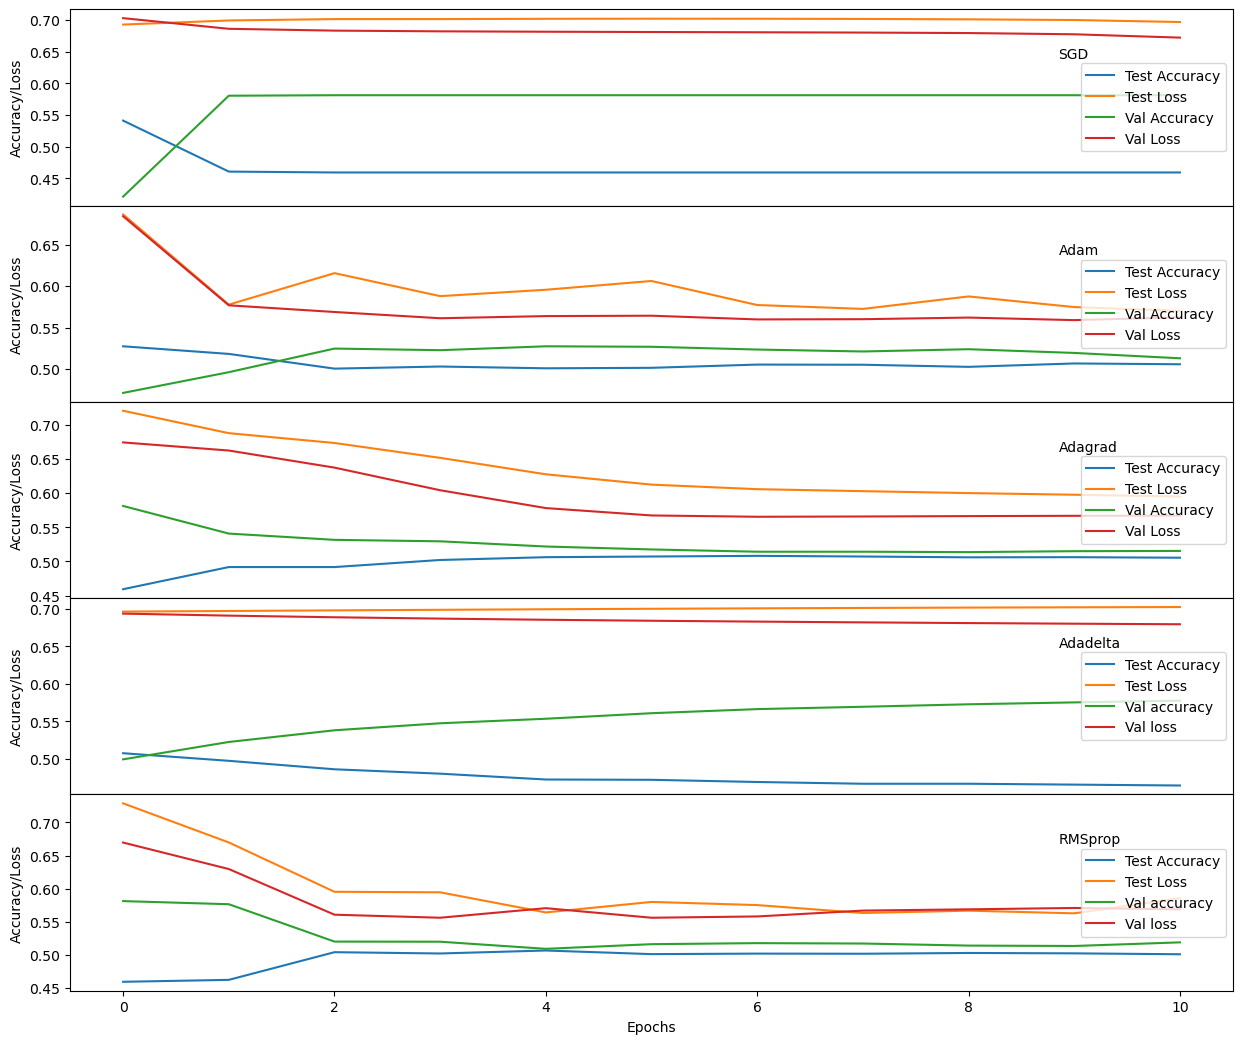

In [282]:
""" Comparing via plot """

fig = plt.figure(figsize=(15,13), dpi=100)
gs = fig.add_gridspec(5,hspace=0)
axs = gs.subplots(sharex=True)

cursor = MultiCursor(fig.canvas,(axs[0],axs[1], axs[2], axs[3], axs[4]),horizOn=False,vertOn=True,color="black",linewidth=1.0)

axs[0].plot(np.arange(0,len(sgd[0])),sgd[0],label='Test Accuracy')
axs[0].plot(np.arange(0,len(sgd[1])),sgd[1],label='Test Loss')
axs[0].plot(np.arange(0,len(sgd[4])),sgd[4],label='Val Accuracy')
axs[0].plot(np.arange(0,len(sgd[5])),sgd[5],label='Val Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy/Loss')
axs[0].legend(loc='center right')
axs[0].annotate('SGD',xy=(0.8,0.5),xytext=(0.85,0.75),xycoords='axes fraction',fontsize=10)

axs[1].plot(np.arange(0,len(adam[0])),adam[0],label='Test Accuracy')
axs[1].plot(np.arange(0,len(adam[1])),adam[1],label='Test Loss')
axs[1].plot(np.arange(0,len(adam[4])),adam[4],label='Val Accuracy')
axs[1].plot(np.arange(0,len(adam[5])),adam[5],label='Val Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy/Loss')
axs[1].legend(loc='center right')
axs[1].annotate('Adam',xy=(0.8,0.5),xytext=(0.85,0.75),xycoords='axes fraction',fontsize=10)

axs[2].plot(np.arange(0,len(adagrad[0])),adagrad[0],label='Test Accuracy')
axs[2].plot(np.arange(0,len(adagrad[1])),adagrad[1],label='Test Loss')
axs[2].plot(np.arange(0,len(adagrad[4])),adagrad[4],label='Val Accuracy')
axs[2].plot(np.arange(0,len(adagrad[5])),adagrad[5],label='Val Loss')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy/Loss')
axs[2].legend(loc='center right')
axs[2].annotate('Adagrad',xy=(0.8,0.5),xytext=(0.85,0.75),xycoords='axes fraction',fontsize=10)

axs[3].plot(np.arange(0,len(adadelta[0])),adadelta[0],label='Test Accuracy')
axs[3].plot(np.arange(0,len(adadelta[1])),adadelta[1],label='Test Loss')
axs[3].plot(np.arange(0,len(adadelta[4])),adadelta[4],label='Val accuracy')
axs[3].plot(np.arange(0,len(adadelta[5])),adadelta[5],label='Val loss')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Accuracy/Loss')
axs[3].legend(loc='center right')
axs[3].annotate('Adadelta',xy=(0.8,0.5),xytext=(0.85,0.75),xycoords='axes fraction',fontsize=10)

axs[4].plot(np.arange(0,len(rmsprop[0])),rmsprop[0],label='Test Accuracy')
axs[4].plot(np.arange(0,len(rmsprop[1])),rmsprop[1],label='Test Loss')
axs[4].plot(np.arange(0,len(rmsprop[4])),rmsprop[4],label='Val accuracy')
axs[4].plot(np.arange(0,len(rmsprop[5])),rmsprop[5],label='Val loss')
axs[4].set_xlabel('Epochs')
axs[4].set_ylabel('Accuracy/Loss')
axs[4].legend(loc='center right')
axs[4].annotate('RMSprop',xy=(0.8,0.5),xytext=(0.85,0.75),xycoords='axes fraction',fontsize=10)

plt.show()

In the next section, we used a new metric that subtracted the mean accuracy of the model (across train, test and validation) from the mean loss of the model (across train, test and validation). This means that the smaller the value of the plot becomes, the bettter the model preformed on average. 

In [283]:
new_metric_sgd_test_loss = [x.numpy() for x in  sgd[1]] 
new_metric_sgd_test_acc = [x.numpy() for x in  sgd[0]]
new_metric_sgd_train_loss = [x.numpy() for x in  sgd[3]] 
new_metric_sgd_train_acc = [x.numpy() for x in  sgd[2]]
new_metric_sgd_val_loss = [x.numpy() for x in  sgd[5]]
new_metric_sgd_val_acc = [x.numpy() for x in  sgd[4]]

new_metric_sgd_penalty_test_loss = [x.numpy() for x in  sgd_penalty[1]]
new_metric_sgd_penalty_test_acc = [x.numpy() for x in  sgd_penalty[0]]
new_metric_sgd_penalty_train_loss = [x.numpy() for x in  sgd_penalty[3]]
new_metric_sgd_penalty_train_acc = [x.numpy() for x in  sgd_penalty[2]]
new_metric_sgd_penalty_val_loss = [x.numpy() for x in  sgd_penalty[5]]
new_metric_sgd_penalty_val_acc = [x.numpy() for x in  sgd_penalty[4]]

new_metric_sgd_penalty_dropout_test_loss = [x.numpy() for x in  sgd_penalty_dropout[1]]
new_metric_sgd_penalty_dropout_test_acc = [x.numpy() for x in  sgd_penalty_dropout[0]]
new_metric_sgd_penalty_dropout_train_loss = [x.numpy() for x in  sgd_penalty_dropout[3]]
new_metric_sgd_penalty_dropout_train_acc = [x.numpy() for x in  sgd_penalty_dropout[2]]
new_metric_sgd_penalty_dropout_val_loss = [x.numpy() for x in  sgd_penalty_dropout[5]]
new_metric_sgd_penalty_dropout_val_acc = [x.numpy() for x in  sgd_penalty_dropout[4]]

# --------------------------------------------------

new_metric_adam_test_loss = [x.numpy() for x in  adam[1]]
new_metric_adam_test_acc = [x.numpy() for x in  adam[0]]
new_metric_adam_train_loss = [x.numpy() for x in  adam[3]]
new_metric_adam_train_acc = [x.numpy() for x in  adam[2]]
new_metric_adam_val_loss = [x.numpy() for x in  adam[5]]
new_metric_adam_val_acc = [x.numpy() for x in  adam[4]]

new_metric_adam_penalty_test_loss = [x.numpy() for x in  adam_penalty[1]]
new_metric_adam_penalty_test_acc = [x.numpy() for x in  adam_penalty[0]]
new_metric_adam_penalty_train_loss = [x.numpy() for x in  adam_penalty[3]]
new_metric_adam_penalty_train_acc = [x.numpy() for x in  adam_penalty[2]]
new_metric_adam_penalty_val_loss = [x.numpy() for x in  adam_penalty[5]]
new_metric_adam_penalty_val_acc = [x.numpy() for x in  adam_penalty[4]]

new_metric_adam_penalty_dropout_test_loss = [x.numpy() for x in  adam_penalty_dropout[1]]
new_metric_adam_penalty_dropout_test_acc = [x.numpy() for x in  adam_penalty_dropout[0]]
new_metric_adam_penalty_dropout_train_loss = [x.numpy() for x in  adam_penalty_dropout[3]]
new_metric_adam_penalty_dropout_train_acc = [x.numpy() for x in  adam_penalty_dropout[2]]
new_metric_adam_penalty_dropout_val_loss = [x.numpy() for x in  adam_penalty_dropout[5]]
new_metric_adam_penalty_dropout_val_acc = [x.numpy() for x in  adam_penalty_dropout[4]]

# --------------------------------------------------

new_metric_adagrad_test_loss = [x.numpy() for x in  adagrad[1]]
new_metric_adagrad_test_acc = [x.numpy() for x in  adagrad[0]]
new_metric_adagrad_train_loss = [x.numpy() for x in  adagrad[3]]
new_metric_adagrad_train_acc = [x.numpy() for x in  adagrad[2]]
new_metric_adagrad_val_loss = [x.numpy() for x in  adagrad[5]]
new_metric_adagrad_val_acc = [x.numpy() for x in  adagrad[4]]

new_metric_adagrad_penalty_test_loss = [x.numpy() for x in  adagrad_penalty[1]]
new_metric_adagrad_penalty_test_acc = [x.numpy() for x in  adagrad_penalty[0]]
new_metric_adagrad_penalty_train_loss = [x.numpy() for x in  adagrad_penalty[3]]
new_metric_adagrad_penalty_train_acc = [x.numpy() for x in  adagrad_penalty[2]]
new_metric_adagrad_penalty_val_loss = [x.numpy() for x in  adagrad_penalty[5]]
new_metric_adagrad_penalty_val_acc = [x.numpy() for x in  adagrad_penalty[4]]

new_metric_adagard_penalty_dropout_test_loss = [x.numpy() for x in  adagrad_penalty_dropout[1]]
new_metric_adagrad_penalty_dropout_test_acc = [x.numpy() for x in  adagrad_penalty_dropout[0]]
new_metric_adagrad_penalty_dropout_train_loss = [x.numpy() for x in  adagrad_penalty_dropout[3]]
new_metric_adagrad_penalty_dropout_train_acc = [x.numpy() for x in  adagrad_penalty_dropout[2]]
new_metric_adagrad_penalty_dropout_val_loss = [x.numpy() for x in  adagrad_penalty_dropout[5]]
new_metric_adagrad_penalty_dropout_val_acc = [x.numpy() for x in  adagrad_penalty_dropout[4]]

# --------------------------------------------------

new_metric_rmsprop_test_loss = [x.numpy() for x in  rmsprop[1]]
new_metric_rmsprop_test_acc = [x.numpy() for x in  rmsprop[0]]
new_metric_rmsprop_train_loss = [x.numpy() for x in  rmsprop[3]]
new_metric_rmsprop_train_acc = [x.numpy() for x in  rmsprop[2]]
new_metric_rmsprop_val_loss = [x.numpy() for x in  rmsprop[5]]
new_metric_rmsprop_val_acc = [x.numpy() for x in  rmsprop[4]]

new_metric_rmsprop_penalty_test_loss = [x.numpy() for x in  rmsprop_penalty[1]]
new_metric_rmsprop_penalty_test_acc = [x.numpy() for x in  rmsprop_penalty[0]]
new_metric_rmsprop_penalty_train_loss = [x.numpy() for x in  rmsprop_penalty[3]]
new_metric_rmsprop_penalty_train_acc = [x.numpy() for x in  rmsprop_penalty[2]]
new_metric_rmsprop_penalty_val_loss = [x.numpy() for x in  rmsprop_penalty[5]]
new_metric_rmsprop_penalty_val_acc = [x.numpy() for x in  rmsprop_penalty[4]]

new_metric_rmsprop_penalty_dropout_test_loss = [x.numpy() for x in  rmsprop_penalty_dropout[1]]
new_metric_rmsprop_penalty_dropout_test_acc = [x.numpy() for x in  rmsprop_penalty_dropout[0]]
new_metric_rmsprop_penalty_dropout_train_loss = [x.numpy() for x in  rmsprop_penalty_dropout[3]]
new_metric_rmsprop_penalty_dropout_train_acc = [x.numpy() for x in  rmsprop_penalty_dropout[2]]
new_metric_rmsprop_penalty_dropout_val_loss = [x.numpy() for x in  rmsprop_penalty_dropout[5]]
new_metric_rmsprop_penalty_dropout_val_acc = [x.numpy() for x in  rmsprop_penalty_dropout[4]]

# --------------------------------------------------

new_metric_adadelta_test_loss = [x.numpy() for x in  adadelta[1]]
new_metric_adadelta_test_acc = [x.numpy() for x in  adadelta[0]]
new_metric_adadelta_train_loss = [x.numpy() for x in  adadelta[3]]
new_metric_adadelta_train_acc = [x.numpy() for x in  adadelta[2]]
new_metric_adadelta_val_loss = [x.numpy() for x in  adadelta[5]]
new_metric_adadelta_val_acc = [x.numpy() for x in  adadelta[4]]

new_metric_adadelta_penalty_test_loss = [x.numpy() for x in  adadelta_penalty[1]]
new_metric_adadelta_penalty_test_acc = [x.numpy() for x in  adadelta_penalty[0]]
new_metric_adadelta_penalty_train_loss = [x.numpy() for x in  adadelta_penalty[3]]
new_metric_adadelta_penalty_train_acc = [x.numpy() for x in  adadelta_penalty[2]]
new_metric_adadelta_penalty_val_loss = [x.numpy() for x in  adadelta_penalty[5]]
new_metric_adadelta_penalty_val_acc = [x.numpy() for x in  adadelta_penalty[4]]

new_metric_adadelta_penalty_dropout_test_loss = [x.numpy() for x in  adadelta_penalty_dropout[1]]
new_metric_adadelta_penalty_dropout_test_acc = [x.numpy() for x in  adadelta_penalty_dropout[0]]
new_metric_adadelta_penalty_dropout_train_loss = [x.numpy() for x in  adadelta_penalty_dropout[3]]
new_metric_adadelta_penalty_dropout_train_acc = [x.numpy() for x in  adadelta_penalty_dropout[2]]
new_metric_adadelta_penalty_dropout_val_loss = [x.numpy() for x in  adadelta_penalty_dropout[5]]
new_metric_adadelta_penalty_dropout_val_acc = [x.numpy() for x in  adadelta_penalty_dropout[4]]

""" SGD """
new_metric_sgd_loss = np.mean([new_metric_sgd_test_loss,new_metric_sgd_train_loss,new_metric_sgd_val_loss],axis=0)
new_metric_sgd_accuracy = np.mean([new_metric_sgd_test_acc,new_metric_sgd_train_acc,new_metric_sgd_val_acc],axis=0)

new_metric_sgd_penalty_loss = np.mean([new_metric_sgd_penalty_test_loss,new_metric_sgd_penalty_train_loss,new_metric_sgd_penalty_val_loss],axis=0)
new_metric_sgd_penalty_accuracy = np.mean([new_metric_sgd_penalty_test_acc,new_metric_sgd_penalty_train_acc,new_metric_sgd_penalty_val_acc],axis=0)

new_metric_sgd_penalty_dropout_loss = np.mean([new_metric_sgd_penalty_dropout_test_loss,new_metric_sgd_penalty_dropout_train_loss,new_metric_sgd_penalty_dropout_val_loss],axis=0)
new_metric_sgd_penalty_dropout_accuracy = np.mean([new_metric_sgd_penalty_dropout_test_acc,new_metric_sgd_penalty_dropout_train_acc,new_metric_sgd_penalty_dropout_val_acc],axis=0)

new_metric_sgd = [x-y for x,y in zip(new_metric_sgd_loss,new_metric_sgd_accuracy)]
new_metric_sgd_penalty = [x-y for x,y in zip(new_metric_sgd_penalty_loss,new_metric_sgd_penalty_accuracy)]
new_metric_sgd_penalty_dropout = [x-y for x,y in zip(new_metric_sgd_penalty_dropout_loss,new_metric_sgd_penalty_dropout_accuracy)]

""" Adam """
new_metric_adam_loss = np.mean([new_metric_adam_test_loss,new_metric_adam_train_loss,new_metric_adam_val_loss],axis=0)
new_metric_adam_accuracy = np.mean([new_metric_adam_test_acc,new_metric_adam_train_acc,new_metric_adam_val_acc],axis=0)

new_metric_adam_penalty_loss = np.mean([new_metric_adam_penalty_test_loss,new_metric_adam_penalty_train_loss,new_metric_adam_penalty_val_loss],axis=0)
new_metric_adam_penalty_accuracy = np.mean([new_metric_adam_penalty_test_acc,new_metric_adam_penalty_train_acc,new_metric_adam_penalty_val_acc],axis=0)

new_metric_adam_penalty_dropout_loss = np.mean([new_metric_adam_penalty_dropout_test_loss,new_metric_adam_penalty_dropout_train_loss,new_metric_adam_penalty_dropout_val_loss],axis=0)
new_metric_adam_penalty_dropout_accuracy = np.mean([new_metric_adam_penalty_dropout_test_acc,new_metric_adam_penalty_dropout_train_acc,new_metric_adam_penalty_dropout_val_acc],axis=0)

new_metric_adam = [x-y for x,y in zip(new_metric_adam_loss,new_metric_adam_accuracy)]
new_metric_adam_penalty = [x-y for x,y in zip(new_metric_adam_penalty_loss,new_metric_adam_penalty_accuracy)]
new_metric_adam_penalty_dropout = [x-y for x,y in zip(new_metric_adam_penalty_dropout_loss,new_metric_adam_penalty_dropout_accuracy)]

""" Adagrad """
new_metric_adagrad_loss = np.mean([new_metric_adagrad_test_loss,new_metric_adagrad_train_loss,new_metric_adagrad_val_loss],axis=0)
new_metric_adagrad_accuracy = np.mean([new_metric_adagrad_test_acc,new_metric_adagrad_train_acc,new_metric_adagrad_val_acc],axis=0)

new_metric_adagrad_penalty_loss = np.mean([new_metric_adagrad_penalty_test_loss,new_metric_adagrad_penalty_train_loss,new_metric_adagrad_penalty_val_loss],axis=0)
new_metric_adagrad_penalty_accuracy = np.mean([new_metric_adagrad_penalty_test_acc,new_metric_adagrad_penalty_train_acc,new_metric_adagrad_penalty_val_acc],axis=0)

new_metric_adagrad_penalty_dropout_loss = np.mean([new_metric_adagard_penalty_dropout_test_loss,new_metric_adagrad_penalty_dropout_train_loss,new_metric_adagrad_penalty_dropout_val_loss],axis=0)
new_metric_adagrad_penalty_dropout_accuracy = np.mean([new_metric_adagrad_penalty_dropout_test_acc,new_metric_adagrad_penalty_dropout_train_acc,new_metric_adagrad_penalty_dropout_val_acc],axis=0)

new_metric_adagrad = [x-y for x,y in zip(new_metric_adagrad_loss,new_metric_adagrad_accuracy)]
new_metric_adagrad_penalty = [x-y for x,y in zip(new_metric_adagrad_penalty_loss,new_metric_adagrad_penalty_accuracy)]
new_metric_adagrad_penalty_dropout = [x-y for x,y in zip(new_metric_adagrad_penalty_dropout_loss,new_metric_adagrad_penalty_dropout_accuracy)]

""" RMSprop """
new_metric_rmsprop_loss = np.mean([new_metric_rmsprop_test_loss,new_metric_rmsprop_train_loss,new_metric_rmsprop_val_loss],axis=0)
new_metric_rmsprop_accuracy = np.mean([new_metric_rmsprop_test_acc,new_metric_rmsprop_train_acc,new_metric_rmsprop_val_acc],axis=0)

new_metric_rmsprop_penalty_loss = np.mean([new_metric_rmsprop_penalty_test_loss,new_metric_rmsprop_penalty_train_loss,new_metric_rmsprop_penalty_val_loss],axis=0)
new_metric_rmsprop_penalty_accuracy = np.mean([new_metric_rmsprop_penalty_test_acc,new_metric_rmsprop_penalty_train_acc,new_metric_rmsprop_penalty_val_acc],axis=0)

new_metric_rmsprop_penalty_dropout_loss = np.mean([new_metric_rmsprop_penalty_dropout_test_loss,new_metric_rmsprop_penalty_dropout_train_loss,new_metric_rmsprop_penalty_dropout_val_loss],axis=0)
new_metric_rmsprop_penalty_dropout_accuracy = np.mean([new_metric_rmsprop_penalty_dropout_test_acc,new_metric_rmsprop_penalty_dropout_train_acc,new_metric_rmsprop_penalty_dropout_val_acc],axis=0)

new_metric_rmsprop = [x-y for x,y in zip(new_metric_rmsprop_loss,new_metric_rmsprop_accuracy)]
new_metric_rmsprop_penalty = [x-y for x,y in zip(new_metric_rmsprop_penalty_loss,new_metric_rmsprop_penalty_accuracy)]
new_metric_rmsprop_penalty_dropout = [x-y for x,y in zip(new_metric_rmsprop_penalty_dropout_loss,new_metric_rmsprop_penalty_dropout_accuracy)]

""" Adadelta """
new_metric_adadelta_loss = np.mean([new_metric_adadelta_test_loss,new_metric_adadelta_train_loss,new_metric_adadelta_val_loss],axis=0)
new_metric_adadelta_accuracy = np.mean([new_metric_adadelta_test_acc,new_metric_adadelta_train_acc,new_metric_adadelta_val_acc],axis=0)

new_metric_adadelta_penalty_loss = np.mean([new_metric_adadelta_penalty_test_loss,new_metric_adadelta_penalty_train_loss,new_metric_adadelta_penalty_val_loss],axis=0)
new_metric_adadelta_penalty_accuracy = np.mean([new_metric_adadelta_penalty_test_acc,new_metric_adadelta_penalty_train_acc,new_metric_adadelta_penalty_val_acc],axis=0)

new_metric_adadelta_penalty_dropout_loss = np.mean([new_metric_adadelta_penalty_dropout_test_loss,new_metric_adadelta_penalty_dropout_train_loss,new_metric_adadelta_penalty_dropout_val_loss],axis=0)
new_metric_adadelta_penalty_dropout_accuracy = np.mean([new_metric_adadelta_penalty_dropout_test_acc,new_metric_adadelta_penalty_dropout_train_acc,new_metric_adadelta_penalty_dropout_val_acc],axis=0)

new_metric_adadelta = [x-y for x,y in zip(new_metric_adadelta_loss,new_metric_adadelta_accuracy)]
new_metric_adadelta_penalty = [x-y for x,y in zip(new_metric_adadelta_penalty_loss,new_metric_adadelta_penalty_accuracy)]
new_metric_adadelta_penalty_dropout = [x-y for x,y in zip(new_metric_adadelta_penalty_dropout_loss,new_metric_adadelta_penalty_dropout_accuracy)]

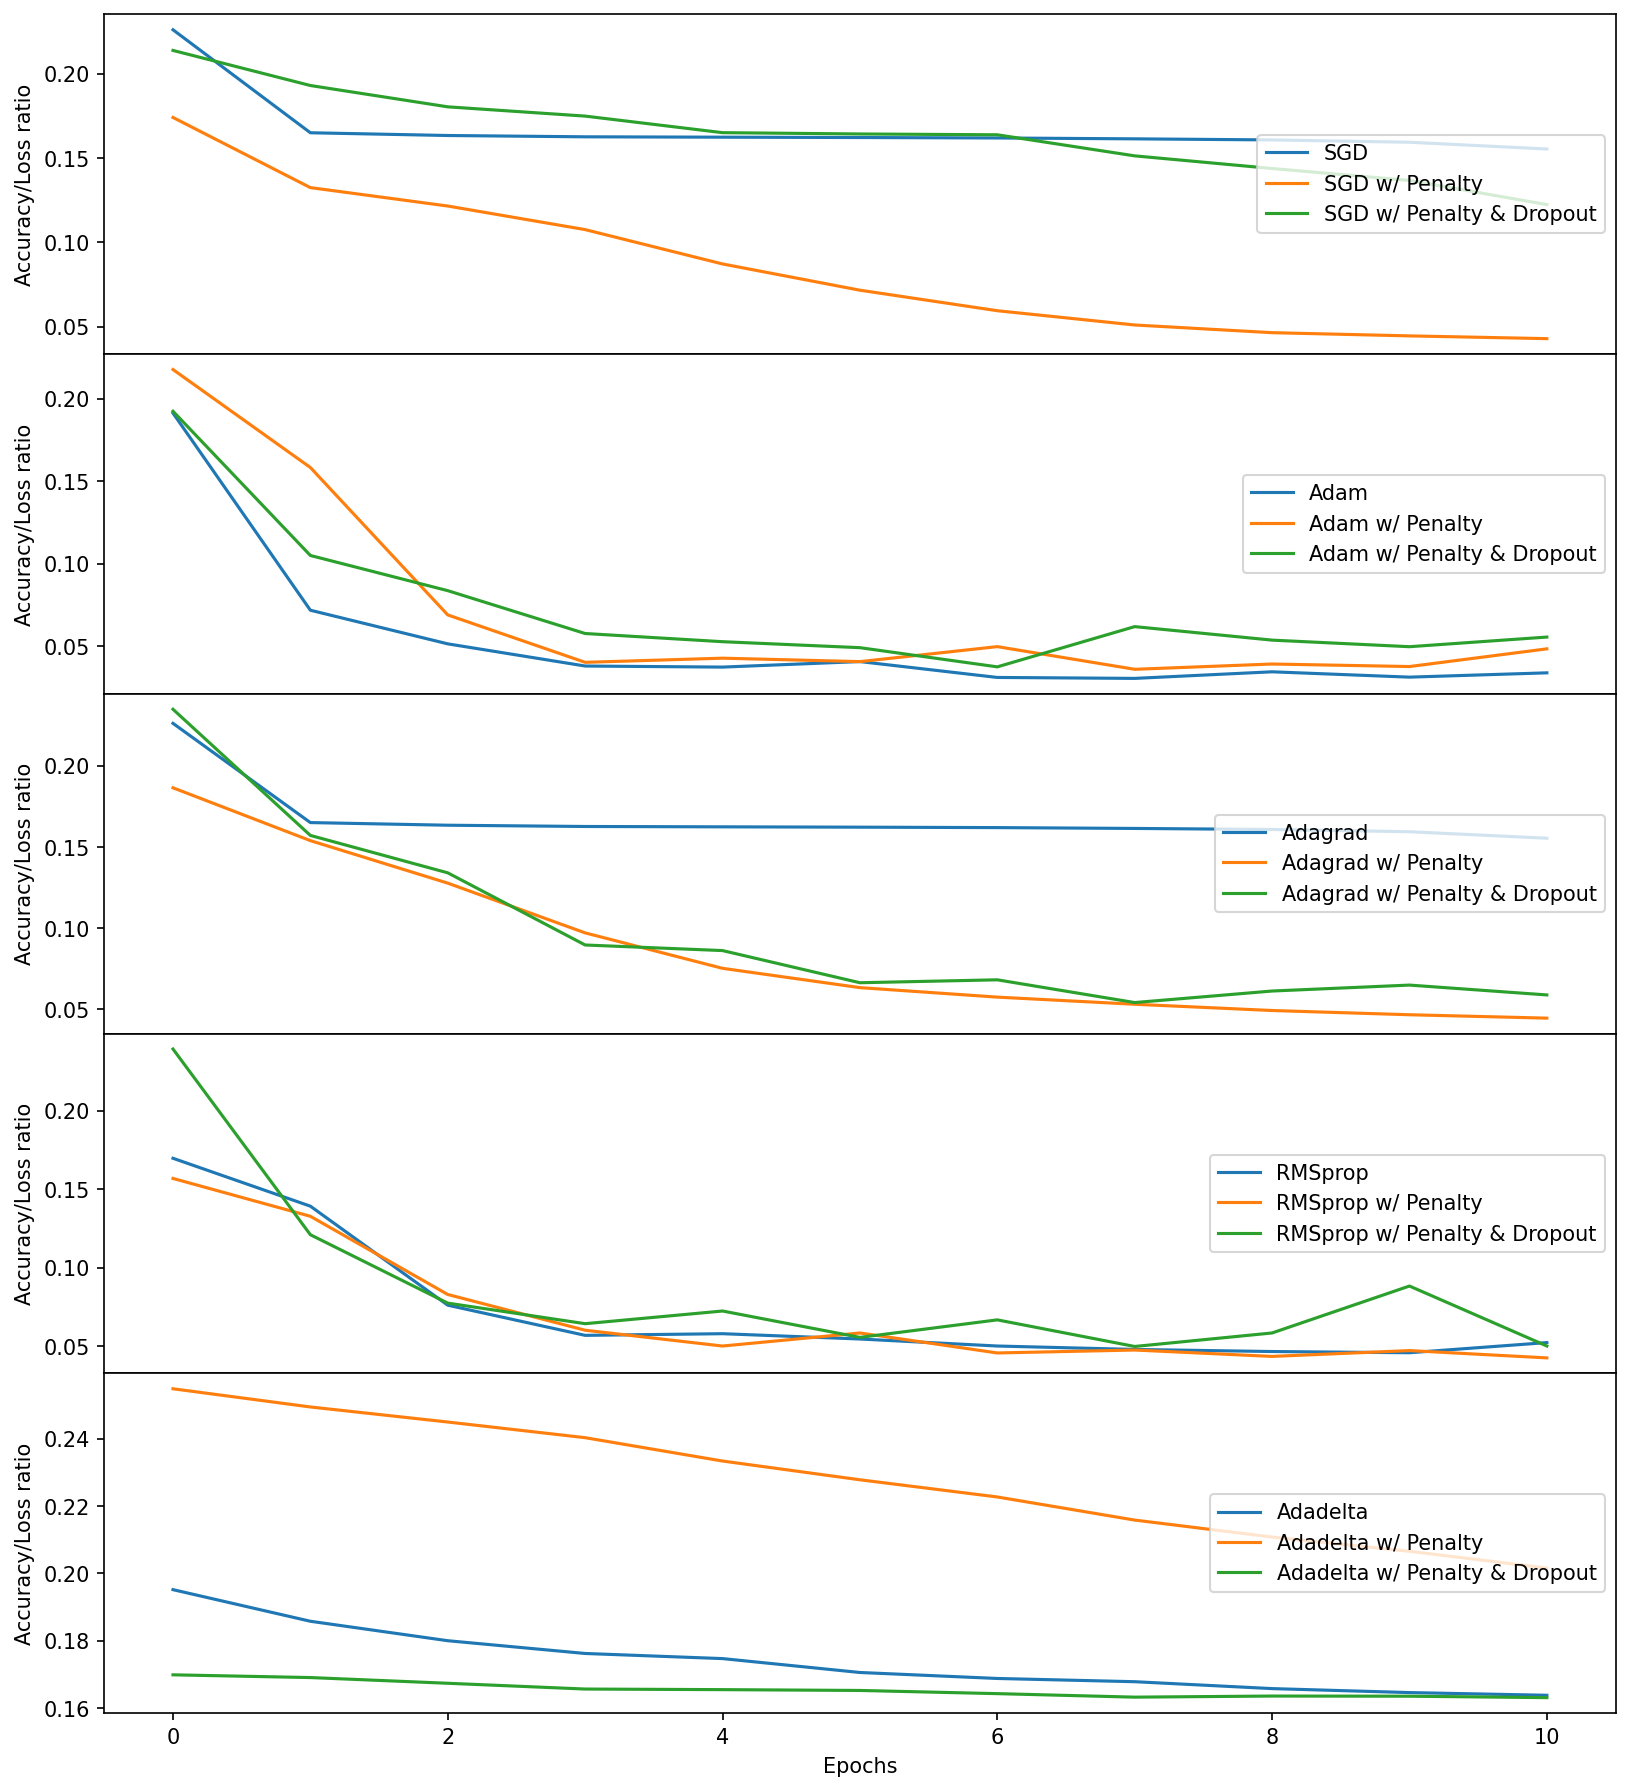

In [284]:
""" Comparing via plot """

fig = plt.figure(figsize=(13,15), dpi=150)
gs = fig.add_gridspec(5,hspace=0)
axs = gs.subplots(sharex=True)

cursor = MultiCursor(fig.canvas,(axs[0],axs[1],axs[2],axs[3],axs[4]),horizOn=False,vertOn=True,color="black",linewidth=1.0)

axs[0].plot(np.arange(0,len(new_metric_sgd)),new_metric_sgd,label='SGD')
axs[0].plot(np.arange(0,len(new_metric_sgd_penalty)),new_metric_sgd_penalty,label='SGD w/ Penalty')
axs[0].plot(np.arange(0,len(new_metric_sgd_penalty_dropout)),new_metric_sgd_penalty_dropout,label='SGD w/ Penalty & Dropout')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy/Loss ratio')
axs[0].legend(loc='center right')

axs[1].plot(np.arange(0,len(new_metric_adam)),new_metric_adam,label='Adam')
axs[1].plot(np.arange(0,len(new_metric_adam_penalty)),new_metric_adam_penalty,label='Adam w/ Penalty')
axs[1].plot(np.arange(0,len(new_metric_adam_penalty_dropout)),new_metric_adam_penalty_dropout,label='Adam w/ Penalty & Dropout')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy/Loss ratio')
axs[1].legend(loc='center right')

axs[2].plot(np.arange(0,len(new_metric_adagrad)),new_metric_sgd,label='Adagrad')
axs[2].plot(np.arange(0,len(new_metric_adagrad_penalty)),new_metric_adagrad_penalty,label='Adagrad w/ Penalty')
axs[2].plot(np.arange(0,len(new_metric_adagrad_penalty_dropout)),new_metric_adagrad_penalty_dropout,label='Adagrad w/ Penalty & Dropout')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy/Loss ratio')
axs[2].legend(loc='center right')

axs[3].plot(np.arange(0,len(new_metric_rmsprop)),new_metric_rmsprop,label='RMSprop')
axs[3].plot(np.arange(0,len(new_metric_rmsprop_penalty)),new_metric_rmsprop_penalty,label='RMSprop w/ Penalty')
axs[3].plot(np.arange(0,len(new_metric_rmsprop_penalty_dropout)),new_metric_rmsprop_penalty_dropout,label='RMSprop w/ Penalty & Dropout')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Accuracy/Loss ratio')
axs[3].legend(loc='center right')

axs[4].plot(np.arange(0,len(new_metric_adadelta)),new_metric_adadelta,label='Adadelta')
axs[4].plot(np.arange(0,len(new_metric_adadelta_penalty)),new_metric_adadelta_penalty,label='Adadelta w/ Penalty')
axs[4].plot(np.arange(0,len(new_metric_adadelta_penalty_dropout)),new_metric_adadelta_penalty_dropout,label='Adadelta w/ Penalty & Dropout')
axs[4].set_xlabel('Epochs')
axs[4].set_ylabel('Accuracy/Loss ratio')
axs[4].legend(loc='center right')


plt.show()

## Results and Interpretation

In [285]:
total_accs = {new_metric_adadelta_penalty_dropout_val_acc[-1]: 'dadelta_penalty_dropout_val_acc', 
                new_metric_adadelta_penalty_val_acc[-1]: 'adadelta_penalty_val_acc', 
                new_metric_adadelta_val_acc[-1]: 'adadelta_val_acc',
                new_metric_rmsprop_penalty_dropout_val_acc[-1]: 'rmsprop_penalty_dropout_val_acc',
                new_metric_rmsprop_penalty_val_acc[-1]: 'rmsprop_penalty_val_acc',
                new_metric_rmsprop_val_acc[-1]: 'rmsprop_val_acc', 
                new_metric_adagrad_penalty_dropout_val_acc[-1]: 'adagrad_penalty_dropout_val_acc', 
                new_metric_adagrad_penalty_val_acc[-1]: 'adagrad_penalty_val_acc', 
                new_metric_adagrad_val_acc[-1]: 'adagrad_val_acc', 
                new_metric_adam_penalty_dropout_val_acc[-1]: 'adam_penalty_dropout_val_acc',
                new_metric_adam_penalty_val_acc[-1]: 'adam_penalty_val_acc', 
                new_metric_adam_val_acc[-1]: 'adam_val_acc', 
                new_metric_sgd_penalty_dropout_val_acc[-1]: 'sgd_penalty_dropout_val_acc', 
                new_metric_sgd_penalty_val_acc[-1]: 'sgd_penalty_val_acc', 
                new_metric_sgd_val_acc[-1]: 'sgd_val_acc'}

dict(sorted(total_accs.items()))

{0.5048828125: 'adam_penalty_val_acc',
 0.505859375: 'adagrad_penalty_dropout_val_acc',
 0.5083984375: 'adam_penalty_dropout_val_acc',
 0.5087890625: 'sgd_penalty_val_acc',
 0.512890625: 'adam_val_acc',
 0.513671875: 'adadelta_penalty_val_acc',
 0.515234375: 'sgd_penalty_dropout_val_acc',
 0.5154296875: 'adagrad_val_acc',
 0.516015625: 'adagrad_penalty_val_acc',
 0.5177734375: 'rmsprop_penalty_dropout_val_acc',
 0.51875: 'rmsprop_penalty_val_acc',
 0.5189453125: 'rmsprop_val_acc',
 0.5685546875: 'dadelta_penalty_dropout_val_acc',
 0.5775390625: 'adadelta_val_acc',
 0.58125: 'sgd_val_acc'}

All in all, we optained our best result on the validation set on:

`SGD without any regularization`


And used the following optimization methods:

Optimization techniques
- SGD: Adds momentum
- Adagrad: Adaptive learning rates for each parameter
- Adadelta and RMSprop: Extensions of Adagrad - take care that the learning rate doesn't get too small
- Adam: Adds bias correction and momentum


Regularization techniques
- L1/L2 regularization: Add penalty to the loss function
- Dropout: Randomly drop out neurons during training


Data normalization
- Normalizing the input data often leads to better performance and stability
- We couldn't observe a significant improvement using normalization
- for the future: Try standardization


Batch size:
- We started off by using a batch size of 20, then increased the batch size to 32. This caused a little performance boost in our model, but strongly depending on the type of optimizer


Units and Layers:
- We tried different architectural baselines for our model. We started off with the same architecture that we used last week and
found that the model performed with an accuracy of about 50%
- We then added an additional hidden layer to the network and increased the number of neurons in each layer. After training the model multiple times, we found that the number of neurons does not really have a big impact on the results, which is very unusual. Also the addition of another layer did not enhance the performance of the model dramatically
- We finally decided to train the model with two hidden layers, one consisting of 8 and the other one consisting of 4 neurons which enhanced the performance of the model by 7% in accuracy on our validation data set when choosing the Adadelta as optimizer (with penalty). 
- Generally, going with a larger network helps to increase its capacity. A deeper model is generally able to cope with large varieties and high dimensionality in the dataset due to a large number of features.
- It is also capable to learn a larger set of mapping functions. Another rule of thumb for the number of width of the
network, ie. the number of neurons in each layer is to have about half the number of neurons in the first layer as there are features
in the data set (12 in our case), and again half the number of neurons in the first layer for the second layer.


